# Index evaluation(calibration & discrimination)
The calibration capacity of a model, an indicator in this case, can be reflected by how agreeable prediction and outcomes are. Whereas the discrimination capacity evaluates how well the model can perform in separating cases with and without outcomes.

In our specific case, the calibration capacity indicates how closely the purchase indicators and the dietary intake reflected by the Food Frequency Questionnaire (FFQ) results are correlated. The discrimination capacity shows how well the purchase indicators can distinguish the people with different dietary intake levels derived from the FFQ questions.


All of the indices are calculated using receipt data, which was retrieved on 19th June, 2021.


Whole grains definition: belong to the grains & dietary fiber content >= 5g/100g products
Added sugar: estimated from the minor food categories and sugar content of products.

Saturated fat
Reducing saturated fat intake to less than 10% of total energy: , 1g fat => 9 Calories

Sugar  
Reducing sugar intake to less than 10% of total energy: a strong recommendation, 1g sugar => 4 Calories
https://www.who.int/mediacentre/news/releases/2015/sugar-guideline/en/


Participant exclusion criteria

1. start from participants who donated their receipts in loyalty cards
2. filter out participants who did not submit the FFQ 
3. rule out participants who did not finish the FFQ for at least 70%
4. rule out participants whose food on record cannot meet at least 1/7 of all card users' need
5. anomaly check

For receipts
1. Users should be in the list of eligible participants
2. Only the receipts within 28days before participants filling out the FFQ were considered.

Complete case analysis: Rows containing NaNs were excluded.





In [59]:
#standard settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

from scipy import stats,interp
from scipy.stats import shapiro, levene, iqr, mannwhitneyu
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd,MultiComparison 
from numpy import var
from scipy.stats.stats import pearsonr
from functools import reduce


In [60]:
def normalizer (unnormalized_column):
    normalized_column = (unnormalized_column - unnormalized_column.mean(axis=0)) / unnormalized_column.std(axis=0)
    return normalized_column

In [61]:
# read files
indices = pd.read_csv('Outputs/indices.csv')
daily_nutrients_ffq_receipt_per_card = pd.read_csv('outputs/daily_nutrients_ffq_receipt_per_card.csv')
daily_added_free_sugar_ffq = pd.read_csv('Data/daily_added_free_sugar_ffq.csv')
daily_weight_per_card = pd.read_csv('Data/daily_weight_per_card.csv')

#assign obese and overweight labels, 
indices['BMI_overweight'] = 0
indices['BMI_obese'] = 0
for i in range(len(indices)):
    if indices.loc[i,'BMI'] > 25:
        indices.loc[i,'BMI_overweight'] = 1
    if indices.loc[i,'BMI'] > 30:
        indices.loc[i,'BMI_obese'] = 1


In [63]:
#merge relevant dfs together
daily_rel_ffq_nutrients = daily_nutrients_ffq_receipt_per_card[['UserId','Energy kcal actual value',
                                                           'Sodium (mg) actual value','Fibers (g) actual value',
                                      'Saturated fatty acids (g) actual value','Sugar (g) actual value']]
fact_list = [daily_rel_ffq_nutrients,daily_weight_per_card,daily_added_free_sugar_ffq, DQI_details]
merged_facts = reduce(lambda  left,right: pd.merge(left,right,on=['UserId'],
                                            how='inner'), fact_list)

#new column calculation


merged_facts['meat portion/1000kcal'] = 1000*merged_facts['meat_portion']/merged_facts['Energy kcal actual value']
merged_facts['vegetable portion/1000kcal'] = 1000*merged_facts['vegetable_portion']/merged_facts['Energy kcal actual value']
merged_facts['fruit portion/1000kcal'] = 1000*merged_facts['fruit_portion']/merged_facts['Energy kcal actual value']
merged_facts['wholegrains portion/1000kcal'] = 1000*merged_facts['wholegrains_portion']/merged_facts['Energy kcal actual value']
merged_facts['sweets portion/1000kcal'] = 1000*merged_facts['sweets_portion']/merged_facts['Energy kcal actual value']

merged_facts['energy density kcal/portion'] = merged_facts['Energy kcal actual value']/merged_facts['total_portion']


merged_facts['Sodium mg/1000kcal'] = 1000*merged_facts['Sodium (mg) actual value']/merged_facts['Energy kcal actual value']
merged_facts['Fibers g/1000kcal'] = 1000*merged_facts['Fibers (g) actual value']/merged_facts['Energy kcal actual value']
merged_facts['Saturated fat g/1000kcal'] = 1000*merged_facts['Saturated fatty acids (g) actual value']/merged_facts['Energy kcal actual value']
merged_facts['Sugar g/1000kcal'] = 1000*merged_facts['Sugar (g) actual value']/merged_facts['Energy kcal actual value']
# Total, added, and free sugar intake was respectively 107 g (±44), 53 g (±36), and 65 g (±40), representing 19%, 9%, and 11% of TEI. Sugar
#  https://www.mdpi.com/2072-6643/11/5/1117
merged_facts['Added sugar g/1000kcal'] = 1000*merged_facts['ffq_added_sugar_g']/merged_facts['Energy kcal actual value']
merged_facts['Free sugar g/1000kcal'] = 1000*merged_facts['ffq_free_sugar_g']/merged_facts['Energy kcal actual value']


In [64]:
  
indices_no_label = indices[['UserId', 'HEI_from_receipts','HETI','GPQI','fsa_nps_di', 'hpi']]
# the lower the fsa_nps_di is, the healthier the shopper is 
indices_no_label['fsa_nps_di'] = - indices_no_label['fsa_nps_di']

# normalize them, make up NPS_HEI, normalize NPS_HEI
indices_no_label_norm = normalizer(indices_no_label.iloc[:,1:])
indices_no_label_norm ['NPS_HEI'] = indices_no_label_norm ['HEI_from_receipts'] + indices_no_label_norm ['fsa_nps_di']
indices_no_label_norm ['NPS_HEI'] = normalizer(indices_no_label_norm ['NPS_HEI'])

# no need to do normalization before correlation analysis
indices_no_label ['NPS_HEI'] = indices_no_label_norm ['NPS_HEI']

index_corr = pd.DataFrame() # Correlation matrix
index_p = pd.DataFrame()  # Matrix of p-values
for x in indices_no_label.columns:
    for y in indices_no_label.columns:
        corr = stats.pearsonr(indices_no_label[x], indices_no_label[y])
        index_corr.loc[x,y] = corr[0]
        index_p.loc[x,y] = corr[1]         
        
indices_no_label_norm['UserId'] = indices_no_label['UserId']        

In [65]:
BMI = indices[['UserId','BMI']]
# merge 
index_fact = indices_no_label.merge(BMI,on='UserId')
index_fact = index_fact.merge(merged_facts,on = ['UserId'])   

indices_for_corr = index_fact[['HEI_from_receipts', 'HETI', 'GPQI', 'fsa_nps_di', 'hpi', 'NPS_HEI']]
absolute_facts_for_corr = index_fact[['meat_portion', 'vegetable_portion', 'fruit_portion',
                             'wholegrains_portion', 'sweets_portion', 'Energy kcal actual value',
                                      'Sodium (mg) actual value', 'Fibers (g) actual value',
                                      'Saturated fatty acids (g) actual value','Sugar (g) actual value',
                                      'ffq_added_sugar_g','ffq_free_sugar_g']]
relative_facts_for_corr = index_fact[['meat portion/1000kcal','vegetable portion/1000kcal','fruit portion/1000kcal', 'wholegrains portion/1000kcal',
                                      'sweets portion/1000kcal', 'energy density kcal/portion','Sodium mg/1000kcal', 'Fibers g/1000kcal', 
                                      'Saturated fat g/1000kcal','Sugar g/1000kcal', 'Added sugar g/1000kcal', 'Free sugar g/1000kcal']]


# no need to do normalization before correlation analysis

absolute_index_fact_corr = pd.DataFrame() # Correlation matrix
absolute_index_fact_p = pd.DataFrame()  # Matrix of p-values
for x in absolute_facts_for_corr.columns:
    for y in indices_for_corr.columns:
        corr = stats.pearsonr(absolute_facts_for_corr[x], indices_for_corr[y])
        absolute_index_fact_corr.loc[x,y] = corr[0]
        absolute_index_fact_p.loc[x,y] = corr[1] 
        
relative_index_fact_corr = pd.DataFrame() # Correlation matrix
relative_index_fact_p = pd.DataFrame()  # Matrix of p-values
for x in relative_facts_for_corr.columns:
    for y in indices_for_corr.columns:
        corr = stats.pearsonr(relative_facts_for_corr[x], indices_for_corr[y])
        relative_index_fact_corr.loc[x,y] = corr[0]
        relative_index_fact_p.loc[x,y] = corr[1] 

In [66]:
absolute_index_fact_corr.to_excel('outputs/abs_index_fact_corr.xlsx', index = True)

In [67]:
relative_index_fact_corr.to_excel('outputs/rel_index_fact_corr.xlsx', index = True)

In [70]:
# relatively significant ones:
# meat_portion, vegetable_portion,fruit_portion,wholegrains_portion,sweets_portion
# added sugar is more significant than free sugar
# sodium, fiber,saturated fat, sugar not significant
absolute_index_fact_p

HEI_from_receipts      HETI      GPQI  \
meat_portion                                     0.437436  0.356904  0.999221   
vegetable_portion                                0.073801  0.089396  0.191031   
fruit_portion                                    0.016499  0.009405  0.043334   
wholegrains_portion                              0.002062  0.028800  0.084732   
sweets_portion                                   0.245488  0.808753  0.737419   
Energy kcal actual value                         0.376653  0.311603  0.401215   
Sodium (mg) actual value                         0.832474  0.503656  0.638631   
Fibers (g) actual value                          0.001620  0.004881  0.095660   
Saturated fatty acids (g) actual value           0.952260  0.750360  0.755551   
Sugar (g) actual value                           0.473173  0.434133  0.709625   
ffq_added_sugar_g                                0.069585  0.199500  0.063663   
ffq_free_sugar_g                                 0.183992  0.559164  0.161909   

                                        fsa_nps_di       hpi   NPS_HEI  
meat_portion                              0.020010  0.576851  0.068223  
vegetable_portion                         0.026379  0.097354  0.017705  
fruit_portion                             0.024091  0.006175  0.005800  
wholegrains_portion                       0.132550  0.206041  0.006865  
sweets_portion                            0.301546  0.981594  0.195418  
Energy kcal actual value                  0.623525  0.590546  0.817512  
Sodium (mg) actual value                  0.259960  0.798632  0.591180  
Fibers (g) actual value                   0.002963  0.104919  0.000264  
Saturated fatty acids (g) actual value    0.177923  0.942521  0.449901  
Sugar (g) actual value                    0.841405  0.622354  0.760962  
ffq_added_sugar_g                         0.344541  0.198416  0.103751  
ffq_free_sugar_g                          0.289336  0.348762  0.158792

In [72]:
# relatively significant ones:
# meat_portion, vegetable_portion,fruit_portion,wholegrains_portion,sweets_portion
# added sugar is more significant than free sugar
# sodium, fiber,saturated fat, 
# sugar not significant
relative_index_fact_p

HEI_from_receipts      HETI      GPQI  \
meat portion/1000kcal                  0.022711  0.023774  0.571334   
vegetable portion/1000kcal             0.073206  0.314172  0.203841   
fruit portion/1000kcal                 0.024975  0.063573  0.066566   
wholegrains portion/1000kcal           0.011353  0.069801  0.346232   
sweets portion/1000kcal                0.063751  0.193403  0.527762   
energy density kcal/portion            0.622610  0.988423  0.343735   
Sodium mg/1000kcal                     0.094224  0.609074  0.391258   
Fibers g/1000kcal                      0.001050  0.026452  0.239109   
Saturated fat g/1000kcal               0.031312  0.096961  0.244184   
Sugar g/1000kcal                       0.779275  0.329626  0.303829   
Added sugar g/1000kcal                 0.002558  0.003535  0.001645   
Free sugar g/1000kcal                  0.023502  0.047920  0.019147   

                                fsa_nps_di       hpi       NPS_HEI  
meat portion/1000kcal         5.457691e-04  0.402237  6.695357e-04  
vegetable portion/1000kcal    2.186045e-03  0.213245  4.103052e-03  
fruit portion/1000kcal        6.676744e-04  0.020731  8.170975e-04  
wholegrains portion/1000kcal  2.932304e-02  0.457316  5.226215e-03  
sweets portion/1000kcal       3.639502e-01  0.523020  1.036122e-01  
energy density kcal/portion   5.301039e-02  0.326843  1.539000e-01  
Sodium mg/1000kcal            2.142464e-02  0.672457  1.876972e-02  
Fibers g/1000kcal             6.007525e-07  0.193487  7.700856e-07  
Saturated fat g/1000kcal      3.989397e-04  0.181286  7.447195e-04  
Sugar g/1000kcal              6.668803e-01  0.431663  9.295720e-01  
Added sugar g/1000kcal        3.839242e-01  0.014184  2.277823e-02  
Free sugar g/1000kcal         3.680997e-01  0.072958  6.250814e-02

In [37]:
relative_index_fact_corr.abs().mean(axis=0)

HEI_from_receipts    0.210157
HETI                 0.163910
GPQI                 0.141036
fsa_nps_di           0.242952
hpi                  0.131970
NPS_HEI              0.264013
dtype: float64

In [38]:
absolute_index_fact_corr.abs().mean(axis=0)

HEI_from_receipts    0.153333
HETI                 0.133830
GPQI                 0.109435
fsa_nps_di           0.154792
hpi                  0.101648
NPS_HEI              0.171391
dtype: float64

# Discrimination capacity comparison




In [39]:
# select relevant indices and facts
# the 5 indices were normalized
# 5 food groups
# 6 nutrients
tertiles_absolute = index_fact[['HEI_from_receipts', 'HETI', 'GPQI', 'fsa_nps_di', 'hpi','NPS_HEI','meat_portion', 
                                'vegetable_portion', 'fruit_portion','wholegrains_portion', 'sweets_portion',
                                'Sodium (mg) actual value','Fibers (g) actual value',
                                'Saturated fatty acids (g) actual value', 'ffq_added_sugar_g']]
    
tertiles_relative = index_fact[['HEI_from_receipts', 'HETI', 'GPQI', 'fsa_nps_di', 'hpi','NPS_HEI',
                                'meat portion/1000kcal', 'vegetable portion/1000kcal','fruit portion/1000kcal', 
                                'wholegrains portion/1000kcal','sweets portion/1000kcal', 'Sodium mg/1000kcal',
                                'Fibers g/1000kcal','Saturated fat g/1000kcal', 'Added sugar g/1000kcal']]


# calculate the overall median and iqr
tertiles_absolute_overall = pd.DataFrame()
tertiles_absolute_overall['median'] = tertiles_absolute.median(axis =0)
tertiles_absolute_overall['iqr'] = iqr(tertiles_absolute, axis =0,interpolation = 'midpoint')

tertiles_relative_overall = pd.DataFrame()
tertiles_relative_overall['median'] = tertiles_relative.median(axis =0)
tertiles_relative_overall['iqr'] = iqr(tertiles_relative, axis =0,interpolation = 'midpoint')

In [40]:
overall_median_iqr = pd.concat([tertiles_absolute_overall,tertiles_relative_overall]).drop_duplicates()
overall_median_iqr.to_excel('outputs/overall_median_iqr.xlsx')

In [41]:
def iqr_column(x):
           return np.max(x) - np.min(x)

In [42]:
def discrimination_detail(x,indicator, absolute = True):
    tertiles_absolute['HEI_cut'] = pd.qcut(tertiles_absolute['HEI_from_receipts'], x, labels=False)
    tertiles_absolute['HETI_cut'] = pd.qcut(tertiles_absolute['HETI'], x, labels=False)
    tertiles_absolute['GPQI_cut'] = pd.qcut(tertiles_absolute['GPQI'], x, labels=False)
    tertiles_absolute['fsa_nps_di_cut'] = pd.qcut(tertiles_absolute['fsa_nps_di'], x, labels=False)
    tertiles_absolute['hpi_cut'] = pd.qcut(tertiles_absolute['hpi'], x, labels=False)
    tertiles_absolute['NPS_HEI_cut'] = pd.qcut(tertiles_absolute['NPS_HEI'], x, labels=False)
    
    tertiles_relative[['HEI_cut', 'HETI_cut','GPQI_cut','fsa_nps_di_cut', 'hpi_cut','NPS_HEI_cut']] = tertiles_absolute[['HEI_cut', 
                                                                                                               'HETI_cut',
                                                                                                               'GPQI_cut', 
                                                                                                               'fsa_nps_di_cut',
                                                                                                               'hpi_cut',
                                                                                                               'NPS_HEI_cut']] 
#  5 food groups
# 4 nutrients 
    absolute_targets = tertiles_absolute[['meat_portion', 'vegetable_portion', 'fruit_portion','wholegrains_portion', 
                                          'sweets_portion', 'Sodium (mg) actual value','Fibers (g) actual value',
                                          'Saturated fatty acids (g) actual value','ffq_added_sugar_g',
                                          'HEI_cut', 'HETI_cut', 'GPQI_cut', 'fsa_nps_di_cut', 'hpi_cut','NPS_HEI_cut']]
    relative_targets = tertiles_relative[['meat portion/1000kcal','vegetable portion/1000kcal', 
                                          'fruit portion/1000kcal', 'wholegrains portion/1000kcal', 
                                          'sweets portion/1000kcal','Sodium mg/1000kcal', 'Fibers g/1000kcal',
                                          'Saturated fat g/1000kcal', 'Added sugar g/1000kcal','HEI_cut',
                                          'HETI_cut', 'GPQI_cut','fsa_nps_di_cut', 'hpi_cut','NPS_HEI_cut']]

    cut_median_list = []
    cut_iqr_list = []
    
    for i in range(15,21):
        if absolute == True:
            cut_facts = tertiles_absolute.iloc[:,[6,7,8,9,10,11,12,13,14,i]]
            indexes = ['meat_portion', 'vegetable_portion', 'fruit_portion','wholegrains_portion','sweets_portion',
                       'Sodium (mg) actual value','Fibers (g) actual value','Saturated fatty acids (g) actual value',
                       'ffq_added_sugar_g']
        else:
            cut_facts = tertiles_relative.iloc[:,[6,7,8,9,10,11,12,13,14,i]]
            indexes = ['meat portion/1000kcal','vegetable portion/1000kcal', 'fruit portion/1000kcal',
                       'wholegrains portion/1000kcal', 'sweets portion/1000kcal','Sodium mg/1000kcal', 
                       'Fibers g/1000kcal','Saturated fat g/1000kcal','Added sugar g/1000kcal']
#         since tertiels_absolute&relative have similar structure, tertiels_absolute&relative.columns[i] are the same
        cut_median_list.append(cut_facts.groupby(tertiles_absolute.columns[i]).median())
        cut_iqr_list.append(cut_facts.groupby(tertiles_absolute.columns[i]).agg(iqr))
       
    tertile_table = pd.DataFrame(index = indexes)
    #initialize the stats and the P-values with 0
    tertile_table['k_stats'] = '0'
    tertile_table['k_ps'] = 0.0
    
    #initialize the stats and the P-values with 0
    for k in range(x-1):
        for l in range(k+1,x):
            tertile_table['u_stats'+str(k)+str(l)] = 0.0
            tertile_table['u_ps'+str(k)+str(l)] = 0.0
            
    for i in range(9):
        if absolute == True:
            comparison_target = absolute_targets.iloc[:,[i,indicator]]
            indicator_target = absolute_targets.iloc[:,indicator]
            
        else:
            comparison_target = relative_targets.iloc[:,[i,indicator]]
            indicator_target = relative_targets.iloc[:,indicator]
        
        cut_details = []
        shapiro_stats = []
        shapiro_ps = []  
        
        for j in range(x):
            jth_array = comparison_target[indicator_target == j].iloc[:,0]
            cut_details.append(jth_array)
            shapiro_stats.append(stats.shapiro(jth_array)[0])
            shapiro_ps.append(stats.shapiro(jth_array)[1])

        lev = stats.levene(*cut_details)
        
        #as absolutely most data doesn't statisfy the parametric test assumptions, we only use non-parametric tests
        k_stat, k_p = stats.kruskal(*cut_details)
        tertile_table['k_stats'][i] = k_stat.astype(str)
        tertile_table['k_ps'][i] = k_p
        
        
        for k in range(x-1):
            for l in range(k+1,x):
                u_stat, u_p = mannwhitneyu(cut_details[k],cut_details[l], alternative = 'two-sided')
                tertile_table['u_stats'+str(k)+str(l)][i] = u_stat.astype(str)
                tertile_table['u_ps'+str(k)+str(l)][i] = u_p
                
  #     add significance star to the results
    tertile_table['k_stats'][tertile_table["k_ps"]<=0.05] += '*'
    
    ttest_point_list = []
    for k in range(x-1):
        for l in range(k+1,x):
            tertile_table['u_stats'+str(k)+str(l)] = tertile_table['u_stats'+str(k)+str(l)].astype(str)
            tertile_table['u_stats'+str(k)+str(l)][tertile_table['u_ps'+str(k)+str(l)]<=0.05] += '*'
            
            test_points = len(tertile_table['k_stats'][tertile_table["k_ps"]<=0.05])
            ttest_point_list.append(len(tertile_table['u_stats'+str(k)+str(l)][tertile_table['u_ps'+str(k)+str(l)]<=0.05])) 
            ttest_points = sum(ttest_point_list)
    
#     indicator-11: cut_median_list was from 0 to 4
    overall_table = pd.concat([cut_median_list[(indicator-11)].T, cut_iqr_list[(indicator-11)].T, tertile_table], axis = 1)
    
    return absolute_targets.columns[indicator],test_points,ttest_points,ttest_point_list,overall_table



In [58]:
print(discrimination_detail(3,9,absolute=False)[0])
discrimination_detail(3,9,absolute=False)[4]

HEI_cut


0            1            2  \
meat portion/1000kcal            0.690609     0.547398     0.495029   
vegetable portion/1000kcal       1.035405     1.274748     1.352827   
fruit portion/1000kcal           0.486016     0.768552     0.787198   
wholegrains portion/1000kcal     0.042628     0.164053     0.112132   
sweets portion/1000kcal          1.614565     1.252931     1.510133   
Sodium mg/1000kcal            1137.290483  1035.447203  1002.783662   
Fibers g/1000kcal               12.258404    13.583193    13.859154   
Saturated fat g/1000kcal        19.584779    19.569898    19.121736   
Added sugar g/1000kcal           5.766149     4.310545     4.030202   

                                       0           1           2  \
meat portion/1000kcal           0.509918    0.614208    0.794214   
vegetable portion/1000kcal      1.009080    1.024372    0.787991   
fruit portion/1000kcal          0.371279    0.497242    0.879063   
wholegrains portion/1000kcal    0.237386    0.199370    0.171180   
sweets portion/1000kcal         0.572438    0.899471    1.019347   
Sodium mg/1000kcal            347.923717  401.953044  332.585299   
Fibers g/1000kcal               7.752069    8.274963    7.030541   
Saturated fat g/1000kcal        5.866502    6.030331    5.752342   
Added sugar g/1000kcal          4.178011    2.199408    2.767104   

                                         k_stats      k_ps u_stats01  \
meat portion/1000kcal         6.411391162235089*  0.040531    574.0*   
vegetable portion/1000kcal    4.3078048990486195  0.116030     513.0   
fruit portion/1000kcal        7.668166515992937*  0.021621     330.0   
wholegrains portion/1000kcal  7.550773808038303*  0.022928     318.5   
sweets portion/1000kcal       3.1264488355073468  0.209460     529.0   
Sodium mg/1000kcal            6.328795901674653*  0.042240    589.0*   
Fibers g/1000kcal             4.6229437341254425  0.099115     357.0   
Saturated fat g/1000kcal       3.571001765035078  0.167713     485.0   
Added sugar g/1000kcal          5.69117568556544  0.058100    589.0*   

                                u_ps01 u_stats02    u_ps02 u_stats12    u_ps12  
meat portion/1000kcal         0.035584    601.0*  0.025829     455.0  0.766945  
vegetable portion/1000kcal    0.239974     385.0  0.340288    301.0*  0.042958  
fruit portion/1000kcal        0.113097    265.0*  0.006377     358.0  0.246094  
wholegrains portion/1000kcal  0.078461    260.0*  0.005082     401.0  0.611485  
sweets portion/1000kcal       0.156295     559.0  0.108690     444.0  0.897455  
Sodium mg/1000kcal            0.019946     583.0  0.050120     413.0  0.744438  
Fibers g/1000kcal             0.239974    304.0*  0.031466     376.0  0.375093  
Saturated fat g/1000kcal      0.452943     571.0  0.074827     517.0  0.216570  
Added sugar g/1000kcal        0.019946     552.0  0.133454     377.0  0.383311

In [44]:
print(discrimination_detail(3,12,absolute=True)[0])
fsa_nps_di_abs = discrimination_detail(3,12,absolute=True)[4]
fsa_nps_di_rel = discrimination_detail(3,12,absolute=False)[4]
fsa_nps_di_abs.to_excel('outputs/fsa_nps_di_abs.xlsx')
fsa_nps_di_rel.to_excel('outputs/fsa_nps_di_rel.xlsx')

fsa_nps_di_cut


In [45]:
tertiles_relative.columns

Index(['HEI_from_receipts', 'HETI', 'GPQI', 'fsa_nps_di', 'hpi', 'NPS_HEI',
       'meat portion/1000kcal', 'vegetable portion/1000kcal',
       'fruit portion/1000kcal', 'wholegrains portion/1000kcal',
       'sweets portion/1000kcal', 'Sodium mg/1000kcal', 'Fibers g/1000kcal',
       'Saturated fat g/1000kcal', 'Added sugar g/1000kcal', 'HEI_cut',
       'HETI_cut', 'GPQI_cut', 'fsa_nps_di_cut', 'hpi_cut', 'NPS_HEI_cut'],
      dtype='object')

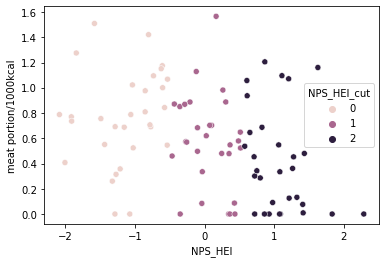

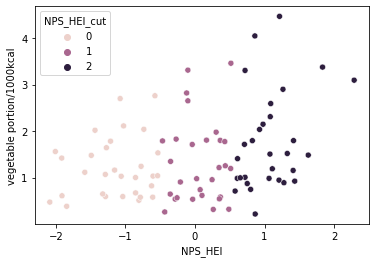

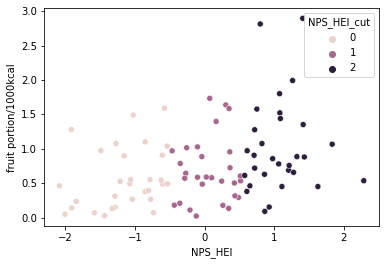

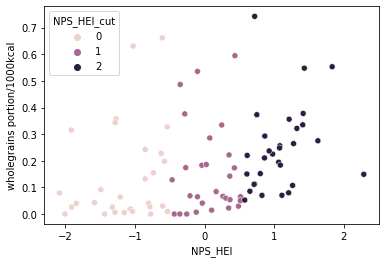

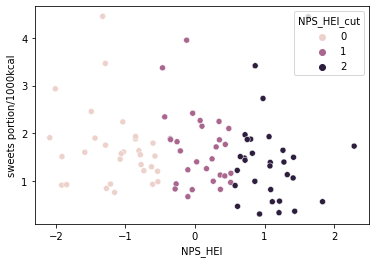

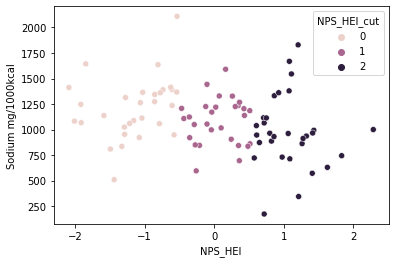

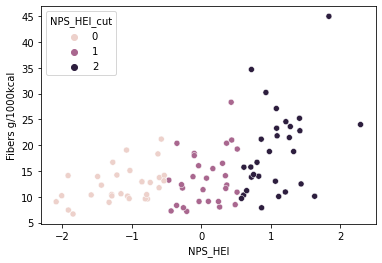

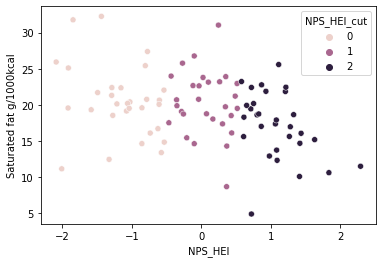

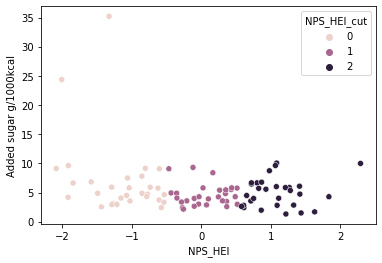

In [46]:
fact_list = ['meat portion/1000kcal', 'vegetable portion/1000kcal',
       'fruit portion/1000kcal', 'wholegrains portion/1000kcal',
       'sweets portion/1000kcal', 'Sodium mg/1000kcal', 'Fibers g/1000kcal',
       'Saturated fat g/1000kcal', 'Added sugar g/1000kcal']
figs = []
for fact in fact_list:
    plt.figure() 
    sns.scatterplot(data=tertiles_relative, x="NPS_HEI", y= fact, hue = 'NPS_HEI_cut')
#     figs.append(x)
# sns.scatterplot(tertiles_relative['FSA_HEI'],tertiles_relative['Added sugar g/1000kcal'])